In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
df_shoes = pd.read_csv('post_analysis_shoes.csv')
df_shoes.shape

(8064, 18)

In [3]:
def plot_value_counts(df,column,kind,rotation=None):
    if(kind == 'barh'):
        plt.figure(figsize=(10,25))
    else:
        plt.figure(figsize=(16,5))
    (df[column].value_counts()/len(df)).plot(kind=kind,title=f"{column}")
    if(rotation):
        plt.xticks(rotation=rotation)
    plt.show()

In [4]:
popular_brands = ['olympikus', 'under_armour', 'nike', 'adidas', 'mizuno','asics','puma','fila']

df_shoes = df_shoes[df_shoes['brand'].isin(popular_brands)]

['olympikus', 'nike', 'adidas', 'asics', 'puma', 'mizuno', 'fila']


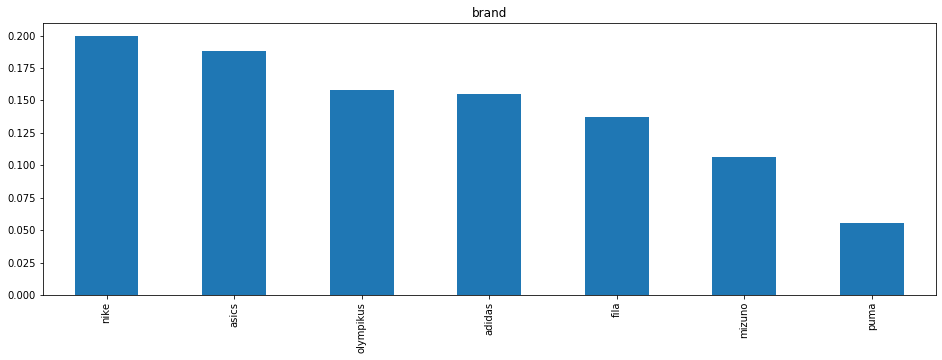

In [5]:
print(list(df_shoes['brand'].unique()))
    
plot_value_counts(df_shoes,'brand','bar')

# Preprocessing Functions

In [6]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
base_path = '/home/raphael/Documents/Projects/netshoes_ml_project/netshoes/images/'
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.15,
                                            horizontal_flip=True,
                                            zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
IMG_SHAPE = (380,380)
epochs = 150

checkpoint_path = './brand_model/drop50_decay1000_dense32_lr003'
efficient_net_url = "https://tfhub.dev/google/efficientnet/b4/feature-vector/1"

if(not os.path.exists(checkpoint_path)):
    os.makedirs(checkpoint_path)

    feature_extractor_layer = hub.KerasLayer(efficient_net_url,
                                         input_shape=IMG_SHAPE+(3,))
    feature_extractor_layer.trainable = False

    model = Sequential([
        feature_extractor_layer,
        Dropout(0.5),
        Dense(32,activation='relu'),
        Dense(df_shoes['brand'].nunique())
    ])
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(checkpoint_path)
    initial_epoch = epochs

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                57376     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 17,731,423
Trainable params: 57,607
Non-trainable params: 17,673,816
_________________________________________________________________


In [9]:
df_shoes['images'] = df_shoes['images'].str.split(',')
df_data = df_shoes.explode('images')[['images','brand']]
df_data['images'] = base_path + df_data['images']
df_data.shape

(17495, 2)

In [10]:
train, valid_test = train_test_split(df_data,
                                test_size=0.15,
                                stratify=df_data['brand'].values,
                                random_state=42)

valid, test = train_test_split(valid_test,
                                test_size=0.25,
                                stratify=valid_test['brand'].values,
                                random_state=42)

train_data_gen = train_image_generator.flow_from_dataframe(train,
                                          x_col='images',
                                          y_col='brand',
                                          shuffle=True,
                                          batch_size=64,
                                          target_size=IMG_SHAPE)

val_data_gen = validation_image_generator.flow_from_dataframe(valid,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

test_data_gen = validation_image_generator.flow_from_dataframe(test,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

Found 14870 validated image filenames belonging to 7 classes.
Found 1968 validated image filenames belonging to 7 classes.
Found 657 validated image filenames belonging to 7 classes.


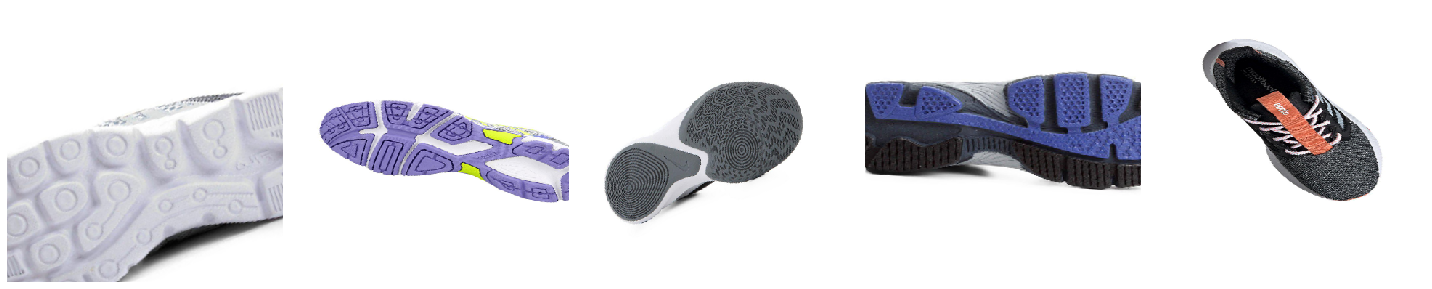

In [11]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

In [12]:
initial_learning_rate = 0.03
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

logdir = f"{checkpoint_path}/logs/scalars/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       monitor='val_acc',
                                       mode='max',
                                       save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0,update_freq='batch')
]



history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    callbacks=callbacks,
    initial_epoch=initial_epoch
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 232 steps, validate for 30 steps
Epoch 1/150
231/232 [============================>.] - ETA: 2s - loss: 1.9066 - acc: 0.3327INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 547s 2s/step - loss: 1.9054 - acc: 0.3328 - val_loss: 1.4779 - val_acc: 0.4068
Epoch 2/150
231/232 [============================>.] - ETA: 2s - loss: 1.5753 - acc: 0.3908INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 535s 2s/step - loss: 1.5751 - acc: 0.3907 - val_loss: 1.3887 - val_acc: 0.4500
Epoch 3/150
232/232 [==============================] - 530s 2s/step - loss: 1.5563 - acc: 0.3986 - val_loss: 1.5310 - val_acc: 0.3792
Epoch 4/150
232/232 [==============================] - 530s 2s/step - loss: 1.5380 - acc: 0.4009 - val_loss: 1.6567 - val_acc: 0.3568
Epoch 5/150
232/232 [==============================] - 531s 2s/step - loss: 1.5171 - acc: 0.4142 - val_loss: 1.4312 - val_acc: 0.4099
Epoch 6/150
231/232 [============================>.] - ETA: 2s - loss: 1.5113 - acc: 0.4140INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 535s 2s/step - loss: 1.5112 - acc: 0.4139 - val_loss: 1.4132 - val_acc: 0.4510
Epoch 7/150
232/232 [==============================] - 529s 2s/step - loss: 1.5156 - acc: 0.4158 - val_loss: 1.4138 - val_acc: 0.4339
Epoch 8/150
232/232 [==============================] - 529s 2s/step - loss: 1.5149 - acc: 0.4211 - val_loss: 1.3874 - val_acc: 0.4495
Epoch 9/150
231/232 [============================>.] - ETA: 2s - loss: 1.5163 - acc: 0.4122INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 534s 2s/step - loss: 1.5180 - acc: 0.4119 - val_loss: 1.3935 - val_acc: 0.4672
Epoch 10/150
232/232 [==============================] - 529s 2s/step - loss: 1.4962 - acc: 0.4237 - val_loss: 1.3574 - val_acc: 0.4500
Epoch 11/150
232/232 [==============================] - 529s 2s/step - loss: 1.4967 - acc: 0.4247 - val_loss: 1.4292 - val_acc: 0.4323
Epoch 12/150
231/232 [============================>.] - ETA: 2s - loss: 1.4927 - acc: 0.4296INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 535s 2s/step - loss: 1.4924 - acc: 0.4298 - val_loss: 1.2988 - val_acc: 0.4953
Epoch 13/150
232/232 [==============================] - 530s 2s/step - loss: 1.4986 - acc: 0.4306 - val_loss: 1.3543 - val_acc: 0.4906
Epoch 14/150
232/232 [==============================] - 532s 2s/step - loss: 1.4699 - acc: 0.4364 - val_loss: 1.3223 - val_acc: 0.4786
Epoch 15/150
232/232 [==============================] - 529s 2s/step - loss: 1.4729 - acc: 0.4388 - val_loss: 1.3517 - val_acc: 0.4589
Epoch 16/150
231/232 [============================>.] - ETA: 2s - loss: 1.4936 - acc: 0.4436INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 535s 2s/step - loss: 1.4930 - acc: 0.4437 - val_loss: 1.3079 - val_acc: 0.5104
Epoch 17/150
232/232 [==============================] - 527s 2s/step - loss: 1.4850 - acc: 0.4449 - val_loss: 1.3122 - val_acc: 0.4938
Epoch 18/150
232/232 [==============================] - 530s 2s/step - loss: 1.4488 - acc: 0.4489 - val_loss: 1.4522 - val_acc: 0.4620
Epoch 19/150
232/232 [==============================] - 529s 2s/step - loss: 1.4582 - acc: 0.4477 - val_loss: 1.3470 - val_acc: 0.4688
Epoch 20/150
231/232 [============================>.] - ETA: 2s - loss: 1.4532 - acc: 0.4461INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 535s 2s/step - loss: 1.4533 - acc: 0.4459 - val_loss: 1.2695 - val_acc: 0.5182
Epoch 21/150
232/232 [==============================] - 529s 2s/step - loss: 1.4684 - acc: 0.4487 - val_loss: 1.4194 - val_acc: 0.4151
Epoch 22/150
232/232 [==============================] - 528s 2s/step - loss: 1.4582 - acc: 0.4504 - val_loss: 1.2903 - val_acc: 0.4943
Epoch 23/150
232/232 [==============================] - 531s 2s/step - loss: 1.4724 - acc: 0.4533 - val_loss: 1.2788 - val_acc: 0.4995
Epoch 24/150
232/232 [==============================] - 529s 2s/step - loss: 1.4652 - acc: 0.4483 - val_loss: 1.2948 - val_acc: 0.4885
Epoch 25/150
232/232 [==============================] - 528s 2s/step - loss: 1.4622 - acc: 0.4516 - val_loss: 1.2793 - val_acc: 0.5177
Epoch 26/150
232/232 [==============================] - 527s 2s/step - loss: 1.4508 - acc: 0.4567 - val_loss: 1.2670 - val_acc: 0.5057
Epoch 27/150
232/232 [==============================] - 529s 2s/step

INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 536s 2s/step - loss: 1.4157 - acc: 0.4615 - val_loss: 1.2264 - val_acc: 0.5276
Epoch 35/150
232/232 [==============================] - 528s 2s/step - loss: 1.4443 - acc: 0.4656 - val_loss: 1.2387 - val_acc: 0.5156
Epoch 36/150
232/232 [==============================] - 528s 2s/step - loss: 1.4404 - acc: 0.4697 - val_loss: 1.2612 - val_acc: 0.4969
Epoch 37/150
232/232 [==============================] - 528s 2s/step - loss: 1.4228 - acc: 0.4710 - val_loss: 1.2618 - val_acc: 0.4870
Epoch 38/150
231/232 [============================>.] - ETA: 2s - loss: 1.4198 - acc: 0.4736INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 534s 2s/step - loss: 1.4198 - acc: 0.4738 - val_loss: 1.1971 - val_acc: 0.5510
Epoch 39/150
232/232 [==============================] - 528s 2s/step - loss: 1.4258 - acc: 0.4755 - val_loss: 1.2207 - val_acc: 0.5359
Epoch 40/150
232/232 [==============================] - 529s 2s/step - loss: 1.4275 - acc: 0.4791 - val_loss: 1.2776 - val_acc: 0.4896
Epoch 41/150
231/232 [============================>.] - ETA: 2s - loss: 1.4240 - acc: 0.4824INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 534s 2s/step - loss: 1.4247 - acc: 0.4821 - val_loss: 1.2014 - val_acc: 0.5609
Epoch 42/150
232/232 [==============================] - 528s 2s/step - loss: 1.4162 - acc: 0.4827 - val_loss: 1.2457 - val_acc: 0.5240
Epoch 43/150
232/232 [==============================] - 528s 2s/step - loss: 1.4020 - acc: 0.4840 - val_loss: 1.2645 - val_acc: 0.5318
Epoch 44/150
232/232 [==============================] - 530s 2s/step - loss: 1.4268 - acc: 0.4843 - val_loss: 1.2015 - val_acc: 0.5573
Epoch 45/150
232/232 [==============================] - 529s 2s/step - loss: 1.4138 - acc: 0.4885 - val_loss: 1.2433 - val_acc: 0.5516
Epoch 46/150
232/232 [==============================] - 528s 2s/step - loss: 1.4001 - acc: 0.4898 - val_loss: 1.2465 - val_acc: 0.5057
Epoch 47/150
231/232 [============================>.] - ETA: 2s - loss: 1.4100 - acc: 0.4908INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 533s 2s/step - loss: 1.4107 - acc: 0.4906 - val_loss: 1.1645 - val_acc: 0.5646
Epoch 48/150
231/232 [============================>.] - ETA: 2s - loss: 1.4092 - acc: 0.4912INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 534s 2s/step - loss: 1.4099 - acc: 0.4904 - val_loss: 1.1857 - val_acc: 0.5703
Epoch 49/150
232/232 [==============================] - 527s 2s/step - loss: 1.3885 - acc: 0.4889 - val_loss: 1.2420 - val_acc: 0.4901
Epoch 50/150
232/232 [==============================] - 529s 2s/step - loss: 1.3971 - acc: 0.4916 - val_loss: 1.2433 - val_acc: 0.5245
Epoch 51/150
232/232 [==============================] - 529s 2s/step - loss: 1.4085 - acc: 0.4928 - val_loss: 1.2468 - val_acc: 0.5396
Epoch 52/150
231/232 [============================>.] - ETA: 2s - loss: 1.3882 - acc: 0.5015INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 534s 2s/step - loss: 1.3882 - acc: 0.5013 - val_loss: 1.1943 - val_acc: 0.5724
Epoch 53/150
232/232 [==============================] - 528s 2s/step - loss: 1.3958 - acc: 0.4960 - val_loss: 1.2517 - val_acc: 0.5396
Epoch 54/150
232/232 [==============================] - 528s 2s/step - loss: 1.3864 - acc: 0.5003 - val_loss: 1.1941 - val_acc: 0.5510
Epoch 55/150
232/232 [==============================] - 529s 2s/step - loss: 1.4256 - acc: 0.4949 - val_loss: 1.2433 - val_acc: 0.5448
Epoch 56/150
231/232 [============================>.] - ETA: 2s - loss: 1.3849 - acc: 0.5069INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 533s 2s/step - loss: 1.3844 - acc: 0.5071 - val_loss: 1.1850 - val_acc: 0.5740
Epoch 57/150
231/232 [============================>.] - ETA: 2s - loss: 1.3868 - acc: 0.5052INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 534s 2s/step - loss: 1.3865 - acc: 0.5050 - val_loss: 1.1863 - val_acc: 0.5828
Epoch 58/150
231/232 [============================>.] - ETA: 2s - loss: 1.3865 - acc: 0.5093INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 535s 2s/step - loss: 1.3860 - acc: 0.5089 - val_loss: 1.1376 - val_acc: 0.5984
Epoch 59/150
232/232 [==============================] - 527s 2s/step - loss: 1.3876 - acc: 0.5150 - val_loss: 1.1570 - val_acc: 0.5818
Epoch 60/150
232/232 [==============================] - 531s 2s/step - loss: 1.3602 - acc: 0.5120 - val_loss: 1.1599 - val_acc: 0.5938
Epoch 61/150
232/232 [==============================] - 529s 2s/step - loss: 1.3765 - acc: 0.5102 - val_loss: 1.1982 - val_acc: 0.5927
Epoch 62/150
232/232 [==============================] - 529s 2s/step - loss: 1.3961 - acc: 0.5090 - val_loss: 1.2204 - val_acc: 0.5656
Epoch 63/150
232/232 [==============================] - 528s 2s/step - loss: 1.3984 - acc: 0.5167 - val_loss: 1.2088 - val_acc: 0.5807
Epoch 64/150
232/232 [==============================] - 528s 2s/step - loss: 1.3689 - acc: 0.5134 - val_loss: 1.1664 - val_acc: 0.5740
Epoch 65/150
232/232 [==============================] - 529s 2s/step

INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 535s 2s/step - loss: 1.3780 - acc: 0.5171 - val_loss: 1.1635 - val_acc: 0.6078
Epoch 71/150
232/232 [==============================] - 530s 2s/step - loss: 1.3821 - acc: 0.5209 - val_loss: 1.1082 - val_acc: 0.6073
Epoch 72/150
232/232 [==============================] - 531s 2s/step - loss: 1.3775 - acc: 0.5172 - val_loss: 1.1760 - val_acc: 0.5797
Epoch 73/150
232/232 [==============================] - 529s 2s/step - loss: 1.3360 - acc: 0.5190 - val_loss: 1.1302 - val_acc: 0.6078
Epoch 74/150
232/232 [==============================] - 533s 2s/step - loss: 1.3597 - acc: 0.5209 - val_loss: 1.1521 - val_acc: 0.5984
Epoch 75/150
232/232 [==============================] - 532s 2s/step - loss: 1.3431 - acc: 0.5205 - val_loss: 1.1428 - val_acc: 0.5974
Epoch 76/150
231/232 [============================>.] - ETA: 2s - loss: 1.3723 - acc: 0.5233INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 536s 2s/step - loss: 1.3723 - acc: 0.5234 - val_loss: 1.1247 - val_acc: 0.6083
Epoch 77/150
232/232 [==============================] - 531s 2s/step - loss: 1.3713 - acc: 0.5214 - val_loss: 1.1804 - val_acc: 0.5875
Epoch 78/150
232/232 [==============================] - 531s 2s/step - loss: 1.3269 - acc: 0.5271 - val_loss: 1.1618 - val_acc: 0.5995
Epoch 79/150
232/232 [==============================] - 531s 2s/step - loss: 1.3243 - acc: 0.5260 - val_loss: 1.1819 - val_acc: 0.5667
Epoch 80/150
231/232 [============================>.] - ETA: 2s - loss: 1.3337 - acc: 0.5277INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 538s 2s/step - loss: 1.3335 - acc: 0.5280 - val_loss: 1.1449 - val_acc: 0.6120
Epoch 81/150
232/232 [==============================] - 533s 2s/step - loss: 1.3460 - acc: 0.5281 - val_loss: 1.1729 - val_acc: 0.5802
Epoch 82/150
232/232 [==============================] - 531s 2s/step - loss: 1.3440 - acc: 0.5297 - val_loss: 1.1641 - val_acc: 0.5490
Epoch 83/150
231/232 [============================>.] - ETA: 2s - loss: 1.3323 - acc: 0.5309INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 537s 2s/step - loss: 1.3315 - acc: 0.5313 - val_loss: 1.0831 - val_acc: 0.6208
Epoch 84/150
232/232 [==============================] - 530s 2s/step - loss: 1.3274 - acc: 0.5299 - val_loss: 1.1045 - val_acc: 0.6099
Epoch 85/150
232/232 [==============================] - 530s 2s/step - loss: 1.3501 - acc: 0.5279 - val_loss: 1.0916 - val_acc: 0.5979
Epoch 86/150
232/232 [==============================] - 531s 2s/step - loss: 1.3224 - acc: 0.5323 - val_loss: 1.0941 - val_acc: 0.6167
Epoch 87/150
232/232 [==============================] - 533s 2s/step - loss: 1.3366 - acc: 0.5314 - val_loss: 1.1256 - val_acc: 0.6172
Epoch 88/150
232/232 [==============================] - 532s 2s/step - loss: 1.3251 - acc: 0.5300 - val_loss: 1.1311 - val_acc: 0.5797
Epoch 89/150
232/232 [==============================] - 531s 2s/step - loss: 1.3389 - acc: 0.5255 - val_loss: 1.1004 - val_acc: 0.6182
Epoch 90/150
232/232 [==============================] - 530s 2s/step

INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 535s 2s/step - loss: 1.3104 - acc: 0.5392 - val_loss: 1.0850 - val_acc: 0.6214
Epoch 104/150
232/232 [==============================] - 531s 2s/step - loss: 1.3158 - acc: 0.5376 - val_loss: 1.1209 - val_acc: 0.5958
Epoch 105/150
232/232 [==============================] - 530s 2s/step - loss: 1.2980 - acc: 0.5401 - val_loss: 1.0918 - val_acc: 0.6167
Epoch 106/150
232/232 [==============================] - 530s 2s/step - loss: 1.3186 - acc: 0.5415 - val_loss: 1.1022 - val_acc: 0.6068
Epoch 107/150
232/232 [==============================] - 531s 2s/step - loss: 1.3065 - acc: 0.5388 - val_loss: 1.1237 - val_acc: 0.6193
Epoch 108/150
232/232 [==============================] - 533s 2s/step - loss: 1.3018 - acc: 0.5376 - val_loss: 1.1140 - val_acc: 0.6177
Epoch 109/150
232/232 [==============================] - 530s 2s/step - loss: 1.3089 - acc: 0.5419 - val_loss: 1.1078 - val_acc: 0.5969
Epoch 110/150
231/232 [============================>.] - ETA: 

INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 536s 2s/step - loss: 1.3102 - acc: 0.5397 - val_loss: 1.0890 - val_acc: 0.6229
Epoch 111/150
232/232 [==============================] - 531s 2s/step - loss: 1.2809 - acc: 0.5492 - val_loss: 1.1291 - val_acc: 0.5964
Epoch 112/150
232/232 [==============================] - 532s 2s/step - loss: 1.2970 - acc: 0.5457 - val_loss: 1.1328 - val_acc: 0.5880
Epoch 113/150
231/232 [============================>.] - ETA: 2s - loss: 1.2934 - acc: 0.5448INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 538s 2s/step - loss: 1.2929 - acc: 0.5447 - val_loss: 1.0858 - val_acc: 0.6240
Epoch 114/150
231/232 [============================>.] - ETA: 2s - loss: 1.2901 - acc: 0.5437INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 537s 2s/step - loss: 1.2890 - acc: 0.5438 - val_loss: 1.0756 - val_acc: 0.6260
Epoch 115/150
232/232 [==============================] - 532s 2s/step - loss: 1.2875 - acc: 0.5480 - val_loss: 1.0975 - val_acc: 0.6151
Epoch 116/150
232/232 [==============================] - 530s 2s/step - loss: 1.2988 - acc: 0.5442 - val_loss: 1.0852 - val_acc: 0.6130
Epoch 117/150
232/232 [==============================] - 532s 2s/step - loss: 1.3119 - acc: 0.5424 - val_loss: 1.0926 - val_acc: 0.6083
Epoch 118/150
232/232 [==============================] - 532s 2s/step - loss: 1.3020 - acc: 0.5407 - val_loss: 1.0889 - val_acc: 0.6052
Epoch 119/150
232/232 [==============================] - 531s 2s/step - loss: 1.2901 - acc: 0.5435 - val_loss: 1.1194 - val_acc: 0.5984
Epoch 120/150
232/232 [==============================] - 533s 2s/step - loss: 1.2778 - acc: 0.5402 - val_loss: 1.1399 - val_acc: 0.5859
Epoch 121/150
232/232 [==============================] - 533s 

INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 538s 2s/step - loss: 1.2751 - acc: 0.5516 - val_loss: 1.0708 - val_acc: 0.6281
Epoch 123/150
232/232 [==============================] - 533s 2s/step - loss: 1.2978 - acc: 0.5485 - val_loss: 1.0811 - val_acc: 0.6208
Epoch 124/150
232/232 [==============================] - 532s 2s/step - loss: 1.3084 - acc: 0.5417 - val_loss: 1.0814 - val_acc: 0.6193
Epoch 125/150
232/232 [==============================] - 535s 2s/step - loss: 1.2834 - acc: 0.5508 - val_loss: 1.1071 - val_acc: 0.6120
Epoch 126/150
232/232 [==============================] - 533s 2s/step - loss: 1.2912 - acc: 0.5481 - val_loss: 1.0878 - val_acc: 0.5995
Epoch 127/150
232/232 [==============================] - 536s 2s/step - loss: 1.2883 - acc: 0.5458 - val_loss: 1.1330 - val_acc: 0.6141
Epoch 128/150
232/232 [==============================] - 535s 2s/step - loss: 1.2806 - acc: 0.5442 - val_loss: 1.1347 - val_acc: 0.5943
Epoch 129/150
232/232 [==============================] - 533s 

INFO:tensorflow:Assets written to: ./brand_model/drop50_decay1000_dense32_lr003/assets


232/232 [==============================] - 540s 2s/step - loss: 1.2930 - acc: 0.5472 - val_loss: 1.0891 - val_acc: 0.6292
Epoch 142/150
232/232 [==============================] - 534s 2s/step - loss: 1.2682 - acc: 0.5514 - val_loss: 1.1102 - val_acc: 0.5958
Epoch 143/150
232/232 [==============================] - 534s 2s/step - loss: 1.2928 - acc: 0.5519 - val_loss: 1.0922 - val_acc: 0.6240
Epoch 144/150
232/232 [==============================] - 535s 2s/step - loss: 1.2726 - acc: 0.5505 - val_loss: 1.1028 - val_acc: 0.6250
Epoch 145/150
232/232 [==============================] - 533s 2s/step - loss: 1.2796 - acc: 0.5514 - val_loss: 1.0775 - val_acc: 0.6073
Epoch 146/150
232/232 [==============================] - 536s 2s/step - loss: 1.2750 - acc: 0.5520 - val_loss: 1.1024 - val_acc: 0.6198
Epoch 147/150
232/232 [==============================] - 533s 2s/step - loss: 1.2751 - acc: 0.5571 - val_loss: 1.1042 - val_acc: 0.6224
Epoch 148/150
232/232 [==============================] - 534s 

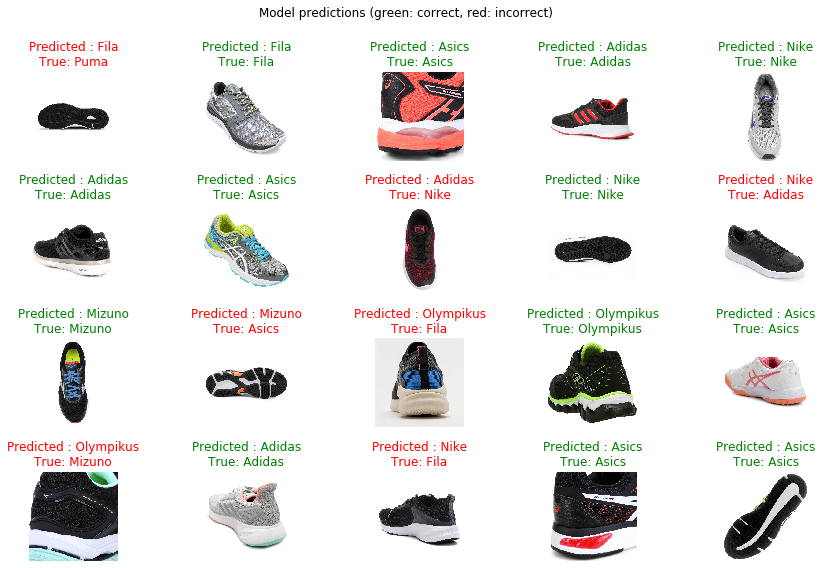

In [16]:
model = tf.keras.models.load_model(checkpoint_path)

class_names = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

image_batch, label_batch = test_data_gen.next()

predicted_batch = model.predict(image_batch)
real_id = np.argmax(label_batch,axis=-1)
real_label_batch = class_names[real_id]
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(4,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(f"Predicted : {predicted_label_batch[n].title()}\nTrue: {real_label_batch[n].title()}",
              color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [14]:
# Evaluation on whole val set
model.evaluate(val_data_gen)

# Evaluation on whole test set
model.evaluate(test_data_gen)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


31/31 [==============================] - 66s 2s/step - loss: 1.0919 - acc: 0.6286
  ...
    to  
  ['...']


  ...
    to  
  ['...']


11/11 [==============================] - 24s 2s/step - loss: 1.0946 - acc: 0.5982


[1.0946052941409024, 0.5981735]